In [1]:
import numpy as np 
import pandas as pd

import torch 
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision 
from torchvision import datasets
from torchvision import transforms
import torchvision.models as models 
from torchmetrics import ConfusionMatrix

import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns

import os

In [2]:
# load data (define folders, download transformed data, load data into data loaders)
train_files = "../input/brain-tumor-classification-mri/Training"
test_files = "../input/brain-tumor-classification-mri/Testing"

data_transforms = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1793, 0.1793, 0.1793],
                        std=[0.1873, 0.1873, 0.1873])
])

train_data = datasets.ImageFolder(train_files, transform=data_transforms)
test_data = datasets.ImageFolder(test_files, transform=data_transforms)
data = torch.utils.data.ConcatDataset([train_data, test_data])

train_data, test_data, valid_data = torch.utils.data.random_split(data, [2594, 300, 370])

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_data, batch_size=batch_size, shuffle=True)

In [3]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"Num images: {len(images)}, Image shape: {images.shape}")

classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

Num images: 32, Image shape: torch.Size([32, 3, 250, 250])


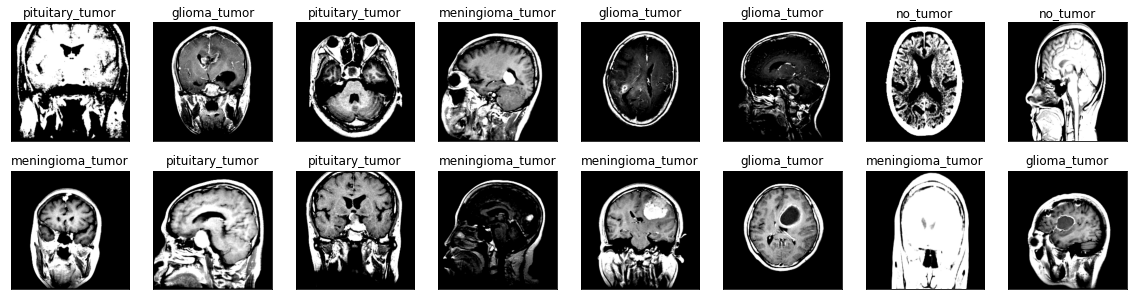

In [4]:
def imgshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
fig = plt.figure(figsize=(20,5))

for i in range(16):
    ax = fig.add_subplot(2, 8, i+1, xticks=[], yticks=[])
    imgshow(images[i])
    ax.set_title(classes[labels[i]])

In [5]:
# building the model (define pre-trained model, freeze parameters, define architecture, connect)

model = models.efficientnet_b0(pretrained=True)

for param in model.parameters():
    param.requires_grad = False 
    
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [6]:

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(in_features=1280, out_features=540)),
                            ('fc2', nn.Linear(in_features=540, out_features=4)),
]))
    
model.classifier = classifier

In [7]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [8]:
epochs = 15

running_loss = 0
min_loss = 1000000

for epoch in range(epochs):
    model.train()
    for images, labels in train_loader:
        
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        
        out = model(images)
        loss = criterion(out, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    ## validation 
    valid_loss = 0
    accuracy = 0
    model.eval()
        
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outp = model.forward(images)
            batch_loss = criterion(outp, labels)
                    
            valid_loss += batch_loss.item()
                    
    # Calculate accuracy
    total_train_loss = running_loss/len(train_loader)
    total_valid_loss = valid_loss/len(valid_loader)
                    
    print("\nEpoch {}, \ntraining loss: {} \nvalidation loss: {}".format(epoch, total_train_loss, total_valid_loss))
        
    if total_valid_loss < min_loss+0.02: 
        print("loss decreased {} --> {}".format(min_loss, total_valid_loss))
        torch.save(model.state_dict(), 'model.brain.pt')
        min_loss = total_valid_loss
        
    running_loss = 0

print("training complete")


Epoch 0, 
training loss: 0.6448465513020027 
validation loss: 0.47231997549533844
loss decreased 1000000 --> 0.47231997549533844

Epoch 1, 
training loss: 0.5016776428716939 
validation loss: 0.5853947525223097

Epoch 2, 
training loss: 0.5114859315316852 
validation loss: 0.4522009380161762
loss decreased 0.47231997549533844 --> 0.4522009380161762

Epoch 3, 
training loss: 0.3937151647377305 
validation loss: 0.4122827760875225
loss decreased 0.4522009380161762 --> 0.4122827760875225

Epoch 4, 
training loss: 0.4537894510459609 
validation loss: 0.4536176721254985

Epoch 5, 
training loss: 0.4870072724070491 
validation loss: 0.44612278913458187

Epoch 6, 
training loss: 0.3718633317365879 
validation loss: 0.3996792609492938
loss decreased 0.4122827760875225 --> 0.3996792609492938

Epoch 7, 
training loss: 0.3509337061607256 
validation loss: 0.48793815573056537

Epoch 8, 
training loss: 0.4255678064939452 
validation loss: 0.4372455117603143

Epoch 9, 
training loss: 0.323881306935

In [9]:
test_loss = 0.0
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))

for images, labels in test_loader:
    labels, images = labels.to(device), images.to(device)
    
    with torch.no_grad():
        output = model.forward(images)
        loss = criterion(output, labels)

        test_loss += loss.item()
        _, pred = torch.max(output, 1)
        correct_tensor = pred.eq(labels.data.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(len(labels)):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0:
             print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i]))) 
    else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
    
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
print(class_total, class_correct)

Test Loss: 0.017416

Test Accuracy of glioma_tumor: 66% (55/83)
Test Accuracy of meningioma_tumor: 89% (67/75)
Test Accuracy of no_tumor: 97% (46/47)
Test Accuracy of pituitary_tumor: 97% (93/95)

Test Accuracy (Overall): 87% (261/300)
[83.0, 75.0, 47.0, 95.0] [55.0, 67.0, 46.0, 93.0]


''

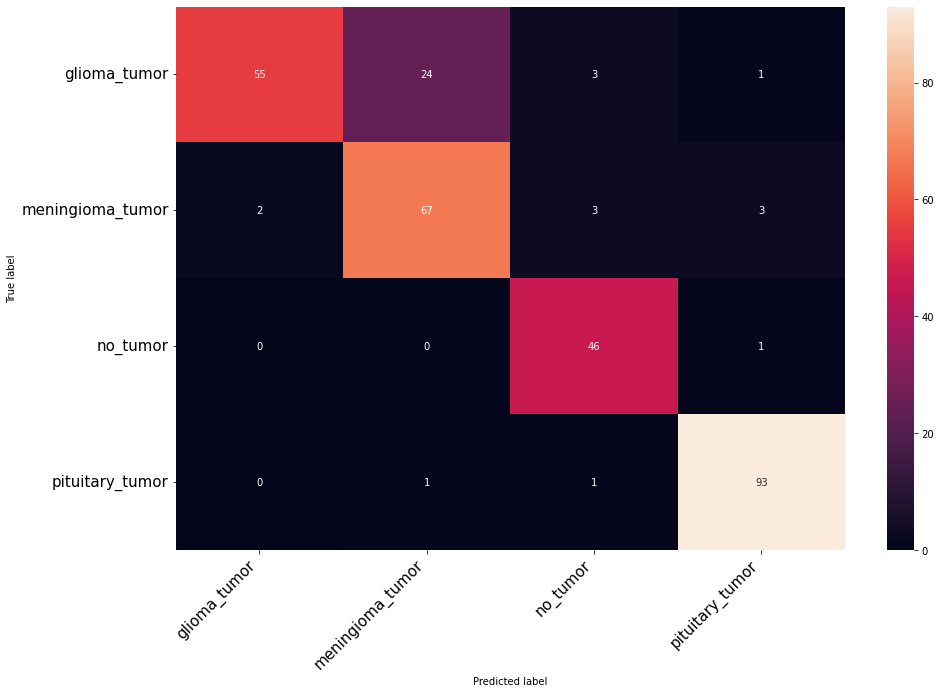

In [10]:

nb_classes = 4
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classe) in enumerate(test_loader):
        inputs = inputs.to(device)
        classe = classe.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classe.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;